In [1]:
from glob import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # relevant only for my environment

In [2]:
# Constants

DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]

resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


In [3]:
import random
import numpy as np
import os
import pretty_midi
import random
from IPython.display import Audio

import matplotlib.pyplot as plt
%matplotlib inline

MIN_NB_ONSETS = 8

drum_dists = {}

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

def play_drum_matrix(mat, tempo=120.0):
    # generate audio
    audio_data = get_audio_from_drum_matrix(mat, tempo=tempo)
    display(Audio(audio_data, rate=44100))
    return audio_data

DRUM_MIDI_MAP = [ # pianoroll to MIDI - reverse
    36, # 0 Kick
    38, # 1 Snare
    42, # 2 Hihat Closed
    46, # 3 Hihat Open
    45, # 4 Tom Low
    47, # 5 Tom Mid
    50, # 6 Tom High
    49, # 7 Clap
    51  # 8 Rim
]

def get_audio_from_drum_matrix(mat, tempo=120.):
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo) # midi object
    pm_inst = pretty_midi.Instrument(0, is_drum=True) # midi instrument
    
    timestep = (60./tempo) / 4. # duration of a 16th note
    for position, timeslot in enumerate(mat):
        for inst, onset in enumerate(timeslot):
            if onset > 0.:
                note_number = DRUM_MIDI_MAP[inst]
                velocity = int(onset * 127.)
                start = timestep * position
                end = timestep * (position + 0.5)
                
                # create a midi note
                note = pretty_midi.Note(velocity=velocity, pitch=note_number, start=start, end=end)
                pm_inst.notes.append(note)
    pm.instruments.append(pm_inst)

    # midi -> audio
    audio_data = pm.fluidsynth()
    return audio_data


In [4]:
import numpy as np

# make sure you have run "0_preprocess_midi.ipynb" in advance
matrices_drums = np.load("./tmp/matrices_drum_groove_genres.npz")['drum_data']
matrices_offsets = np.load("./tmp/matrices_drum_groove_genres.npz")['timeshift']
matrices_genres = np.load("./tmp/matrices_drum_groove_genres.npz")['genre_ids']
GENRES = np.load("./tmp/matrices_drum_groove_genres.npz")['genres']

NB_GENRES = len(GENRES)
print(GENRES)
print(matrices_genres.shape)

# # Filter genres 
# GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
# GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]

# print(GENRES_ID_USED)
# print(GENRES)

# NB_GENRES = len(GENRES)
# print("%d genres we have" % NB_GENRES)

# _drums = []
# _genres = []

# for genre_id, drum in zip(matrices_genres, matrices_drums):
#     if genre_id in GENRES_ID_USED:
#         _drums.append(drum)
#         genre_id = GENRES_ID_USED.index(genre_id)
#         _genres.append(genre_id)

# matrices_drums = np.array(_drums)
# print(matrices_drums.shape)
# matrices_genres = np.array(_genres)
# print(matrices_genres.shape)

['funk' 'rock' 'jazz' 'latin' 'hiphop' 'soul']
(16620,)


In [5]:
# import numpy as np

# # make sure you have run "0_preprocess_midi.ipynb" in advance
# matrices_drums = np.load("./tmp/matrices_drum_gm_electronic.npz")['drum_data']
# matrices_genres = np.load("./tmp/matrices_drum_gm_electronic.npz")['genre_ids']
# GENRES_ALL = np.load("./tmp/matrices_drum_gm_electronic.npz")['genres']

# print(GENRES_ALL)
# print(matrices_genres.shape)

# # Filter genres 
# GENRES_USED = [u'Old Skool', u'DnB', u'Jungle', u'House', u'Breakbeat', u'Garage', u'Techno']
# GENRES_ID_USED = [i for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]
# GENRES = [genre for i, genre in enumerate(GENRES_ALL) if genre in GENRES_USED]

# print(GENRES_ID_USED)
# print(GENRES)

# NB_GENRES = len(GENRES)
# print("%d genres we have" % NB_GENRES)

# _drums = []
# _genres = []

# for genre_id, drum in zip(matrices_genres, matrices_drums):
#     if genre_id in GENRES_ID_USED:
#         _drums.append(drum)
#         genre_id = GENRES_ID_USED.index(genre_id)
#         _genres.append(genre_id)

# matrices_drums = np.array(_drums)
# print(matrices_drums.shape)
# matrices_genres = np.array(_genres)
# print(matrices_genres.shape)

funk 2978


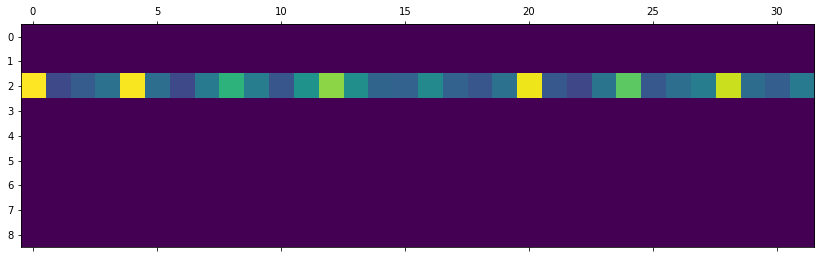

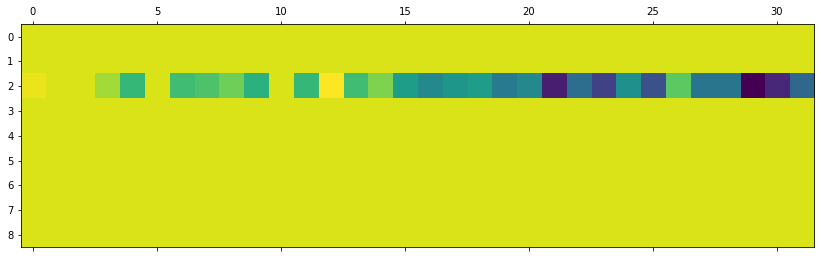

[[ 0.          0.          0.01666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.05        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.16666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.15        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.13333333  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.1         0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.18333333  0.          0.  

rock 6446


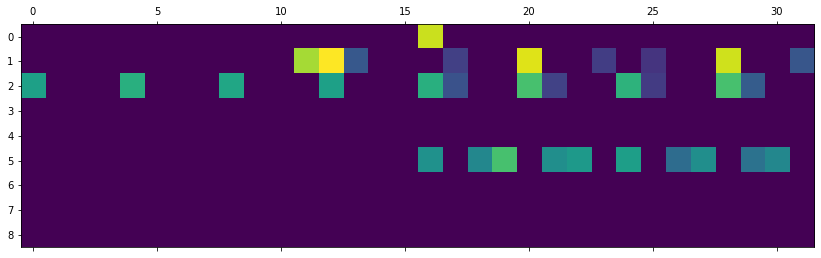

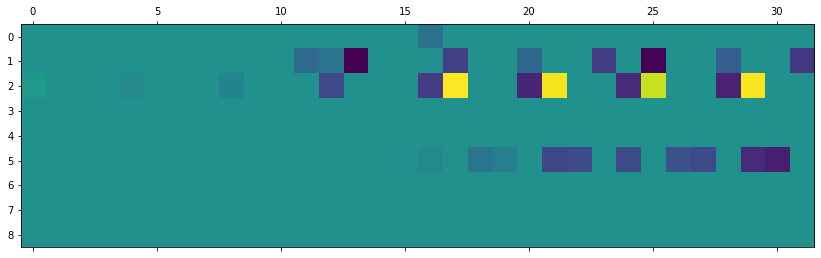

[[ 0.          0.          0.06666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.06666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.1         0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.  

jazz 2141


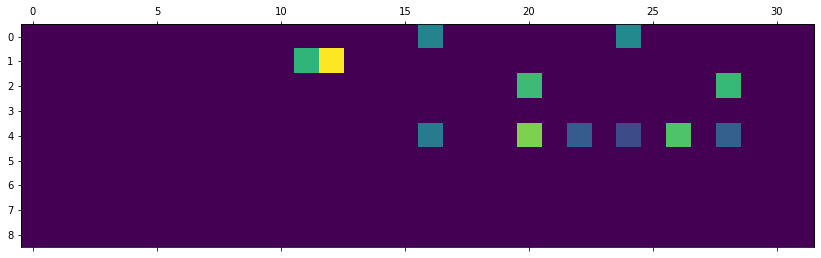

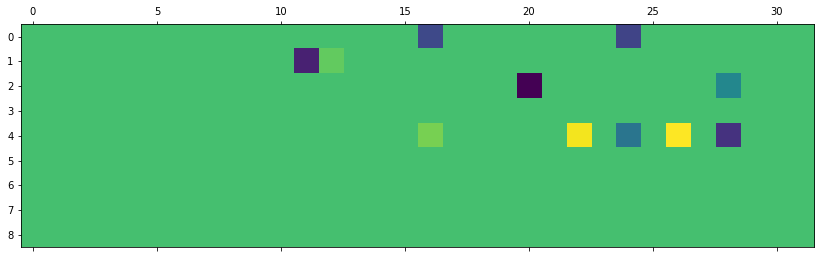

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.  

latin 3569


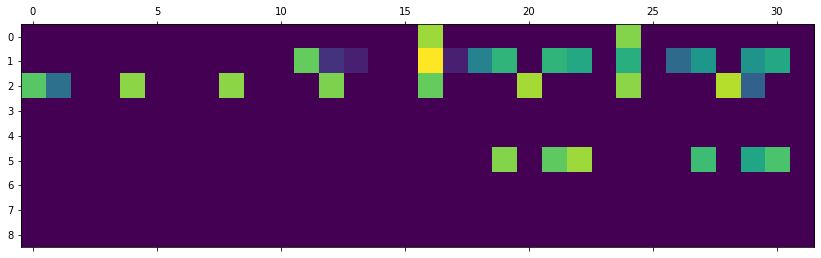

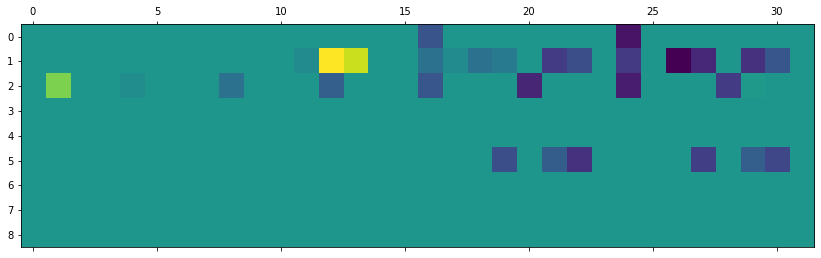

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.51666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.06666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.28333333  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.  

hiphop 868


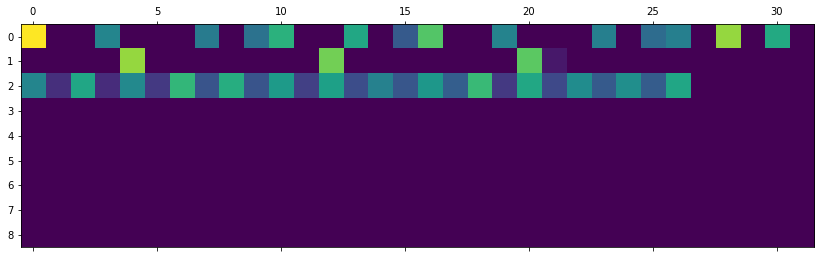

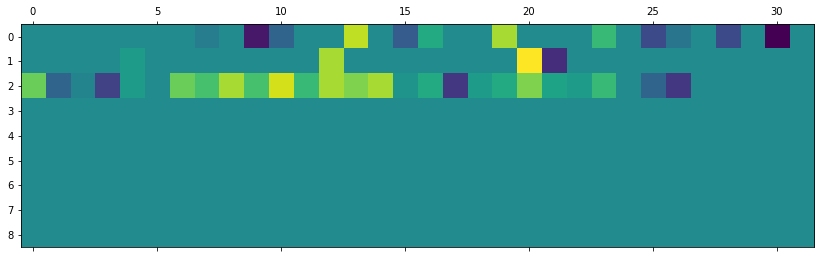

[[ 0.          0.          0.15        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.08333333  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.01666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.15        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.03333333  0.03333333  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.15        0.          0.          0.
   0.          0.          0.        ]
 [-0.03333333  0.          0.11666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.2         0.          0.          0.
   0.          0.          0.        ]
 [-0.21666667  0.          0.11666667  0.          0.  

soul 618


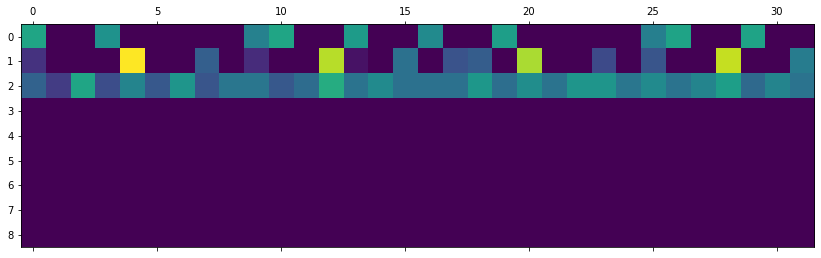

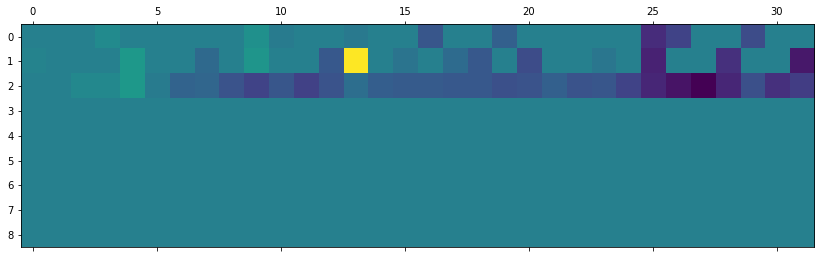

[[ 0.          0.01666667  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.05        0.          0.          0.
   0.          0.          0.        ]
 [ 0.06666667  0.          0.05        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.15        0.15        0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.03333333  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.18333333  0.          0.          0.
   0.          0.          0.        ]
 [ 0.         -0.15       -0.16666667  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.         -0.28333333  0.          0.          0.
   0.          0.          0.        ]
 [ 0.1         0.13333333 -0.36666667  0.          0.  

In [6]:
for i, genre in enumerate(GENRES):
    a = matrices_drums[matrices_genres == i]
    t = matrices_offsets[matrices_genres == i]
    print(genre, int(a.shape[0]))
    plot_drum_matrix(a[0])
    plot_drum_matrix(t[0])
    print (t[0])
    play_drum_matrix(a[0])
    

In [7]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM
from keras.layers import Bidirectional, Lambda, Concatenate, Softmax, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.models import Model
from keras import regularizers

droprate = 0.4

# input
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
offset_input = Input(shape=(len_seq, nb_notes), name='offset_input')  # tensorflow order

x0 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(drum_input) 
x0 = BatchNormalization()(x0)
x0 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x0)
x0 = BatchNormalization()(x0)
#x0 = Dropout(droprate)(x0)

x1 = Bidirectional(LSTM(128, return_sequences=True, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(offset_input) 
x1 = BatchNormalization()(x1)
x1 = Bidirectional(LSTM(128, return_sequences=False, activation='tanh', dropout=droprate, recurrent_dropout=droprate))(x1)
x1 = BatchNormalization()(x1)
#x1 = Dropout(droprate)(x1)

x = Concatenate(axis=-1)([x0, x1])
x = Dropout(droprate)(x)
x = Dense(512, activation='sigmoid')(x)
output = Dense(NB_GENRES, activation='softmax', 
               kernel_regularizer=regularizers.l2(0.01), 
               activity_regularizer=regularizers.l1(0.01))(x)

model = Model([drum_input, offset_input], output)
model.summary()



Using TensorFlow backend.
W1127 20:02:45.164871 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1127 20:02:45.173898 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1127 20:02:45.174787 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1127 20:02:45.262149 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
offset_input (InputLayer)       (None, 32, 9)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32, 256)      141312      drum_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 32, 256)      141312      offset_input[0][0]               
____________________________________________________________________________________________

In [8]:
from datetime import datetime
now = datetime.now()
logdir_prefix = "/tmp/tf_logs/"
logdir = logdir_prefix + now.strftime("%Y%m%d-%H%M%S") 
cmd = "tensorboard --logdir=" + logdir_prefix
print (cmd)

tensorboard --logdir=/tmp/tf_logs/


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import to_categorical 

genre_ids = to_categorical(matrices_genres, num_classes=NB_GENRES)

BATCH_SIZE = 64

tb = TensorBoard(log_dir=logdir, histogram_freq=1, batch_size=BATCH_SIZE, write_grads=True,update_freq='epoch')
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
cp = ModelCheckpoint("./tmp/rythm_classification_groove_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, save_best_only=True, period=1)

optimizer = RMSprop ( lr = 0.0008 ) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                      metrics=['accuracy'])

model.fit([matrices_drums, matrices_offsets], genre_ids, 
        shuffle=True, batch_size=BATCH_SIZE, epochs=100, verbose=1, validation_split=0.2, callbacks=[tb, es, cp])

W1127 20:02:47.461762 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1127 20:02:47.466332 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.

W1127 20:02:47.608900 140539350714112 deprecation.py:323] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 13296 samples, validate on 3324 samples


W1127 20:02:53.077192 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/callbacks.py:1120: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.

W1127 20:03:23.625649 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/callbacks.py:1122: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W1127 20:03:23.627922 140539350714112 deprecation_wrapper.py:119] From /home/nao/anaconda3/envs/p3/lib/python3.7/site-packages/keras/callbacks.py:1125: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
13296/13296 [==============================] - 52s 4ms/step - loss: 2.1570 - acc: 0.4378 - val_loss: 2.2044 - val_acc: 0.3601

Epoch 00001: val_loss improved from inf to 2.20443, saving model to ./tmp/rythm_classification_groove_01-2.20.hdf5
Epoch 2/100
13296/13296 [==============================] - 45s 3ms/step - loss: 2.0264 - acc: 0.4884 - val_loss: 1.8661 - val_acc: 0.5511

Epoch 00002: val_loss improved from 2.20443 to 1.86605, saving model to ./tmp/rythm_classification_groove_02-1.87.hdf5
Epoch 3/100
13296/13296 [==============================] - 44s 3ms/step - loss: 1.9312 - acc: 0.5253 - val_loss: 2.1770 - val_acc: 0.3812

Epoch 00003: val_loss did not improve from 1.86605
Epoch 4/100
13296/13296 [==============================] - 44s 3ms/step - loss: 1.8873 - acc: 0.5396 - val_loss: 2.1430 - val_acc: 0.3736

Epoch 00004: val_loss did not improve from 1.86605
Epoch 5/100
13296/13296 [==============================] - 44s 3ms/step - loss: 1.7971 - acc: 0.5772 - val_l

model.save("./tmp/rhythm_classification_groove_with_offset.h5")